In [1]:
import os
from os.path import join
import glob
import json

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.utils import resample


from naturalcogsci.helpers import get_project_root

PROJECT_ROOT = get_project_root()

mpl.rcParams.update(mpl.rc_params_from_file(join(PROJECT_ROOT, ".matplotlibrc")))

FIGWIDTH = mpl.rcParams["figure.figsize"][0]
CMAP = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
CATEGORYTRIALS = 120
REWARDTRIALS = 60
SMALLER_SIZE = 6



with open(join(PROJECT_ROOT, "data", "model_plot_params.json")) as f:
    plot_params = json.load(f)
plot_params = {k.replace("/", "_"): v for k, v in plot_params.items()}
main_feature_names = list(plot_params.keys())

In [2]:
dfs = glob.glob(
    join(
        PROJECT_ROOT,
        "data",
        "learner_behavioural",
        "category_learning",
        "*_l2_original.csv",
    )
)
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df["nll"] = -np.where(
    model_df.choice == 1, np.log(model_df.prob),np.log(1 - model_df.prob)
)
model_df = model_df[model_df.features.isin(main_feature_names)]
model_df["return"] = np.where(np.round(model_df.prob) == model_df.true_category_binary, 1, 0)
chance_level = -model_df.participant.nunique() * CATEGORYTRIALS * np.log(0.5)
model_df = model_df.groupby("features").agg({"nll": "sum", "return": "mean"}).reset_index()
model_df = model_df.sort_values(by="nll", ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["feature_key"] = model_df["features"]
model_df["alignment"] = model_df["features"].apply(lambda x: plot_params[x]["alignment"])
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])
model_df["nll"] = 1 - model_df.nll/chance_level
model_df.loc[model_df.nll==1]["nll"] = 0
category_model_df = model_df

In [3]:
dfs = glob.glob(
    join(
        PROJECT_ROOT,
        "data",
        "learner_behavioural",
        "reward_learning",
        "*_l2_original.csv",
    )
)
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df = model_df[model_df.features.isin(main_feature_names)]
model_df["prob"] = np.where(model_df.prob == 1, 0.99999, model_df.prob)
model_df["nll"] = -np.where(
    model_df.choice == 1, np.log(model_df.prob), np.log(1 - model_df.prob)
)
chance_level = -model_df.participant.nunique() * REWARDTRIALS * np.log(0.5)
model_df["model_choice"] = np.where(model_df.right_value > model_df.left_value, 1,0)
model_df["best_side"] = np.where(model_df.right_reward > model_df.left_reward, 1, 0)
model_df["return"] = np.where(model_df.model_choice == model_df.best_side,1,0)
model_df = model_df.groupby("features").agg({"nll": "sum", "return": "mean"}).reset_index()
model_df = model_df.sort_values(by="nll", ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["alignment"] = model_df["features"].apply(lambda x: plot_params[x]["alignment"])
model_df["feature_key"] = model_df["features"]
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])
model_df["nll"] = 1 - model_df.nll/chance_level
reward_model_df = model_df

In [4]:
merged_df = pd.merge(
    reward_model_df[["features", "color", "nll", "return","feature_key"]],
    category_model_df[["features", "color", "nll", "return","feature_key"]],
    on=["features", "color", "feature_key"],
    suffixes=("_reward", "_category"),
)

merged_df["nll"] = (merged_df["nll_reward"] + merged_df["nll_category"])/2
merged_df["return"] = (merged_df["return_reward"] + merged_df["return_category"])/2
merged_df.drop(["return_reward", "return_category"], axis=1, inplace=True)
merged_df.drop(["nll_reward", "nll_category"], axis=1, inplace=True)
merged_df["model_size"] = model_df["feature_key"].apply(
    lambda x: plot_params[x]["size"]
)
merged_df["zero_shot"] = model_df["feature_key"].apply(
    lambda x: plot_params[x]["zero-shot"]
)
merged_df["probing"] = model_df["feature_key"].apply(
    lambda x: plot_params[x]["probing"]
)

merged_df["training_data"] = model_df["feature_key"].apply(
    lambda x: plot_params[x]["data-size"]
)

r2_dfs = glob.glob(join(PROJECT_ROOT, "data", "ID", "*.csv"))

dfs = []
for file_path in r2_dfs:
    file_name = os.path.basename(file_path).split(".")[0]
    df = pd.read_csv(file_path)
    df["features"] = file_name
    dfs.append(df)

id_df = pd.concat(dfs, ignore_index=True)

id_df = id_df[id_df.features.isin(main_feature_names)]

id_df["color"] = id_df["features"].apply(lambda x: plot_params[x]["colour"])
id_df["features"] = id_df["features"].apply(lambda x: plot_params[x]["name"])

id_df = pd.merge(id_df, merged_df, on=["features", "color"], how="outer")
id_df=id_df[id_df.color.isin(["self-supervised","supervised","multimodal"])]

In [5]:


# Filter the DataFrame
id_df = id_df[id_df.color.isin(["multimodal", "self-supervised", "supervised"])]

# Initialize lists to store results
model_types = []
test_types = []
correlation_values = []
p_values = []
ci_lower_bounds = []
ci_upper_bounds = []

# Number of bootstrap samples
n_bootstrap_samples = 1000
confidence_level = 0.95

# Function to calculate bootstrap confidence intervals
def bootstrap_ci(x, y, n_bootstrap_samples, confidence_level):
    bootstrap_samples = []
    for _ in range(n_bootstrap_samples):
        resampled_x, resampled_y = resample(x, y)
        corr, _ = spearmanr(resampled_x, resampled_y)
        bootstrap_samples.append(corr)
    lower_bound = np.percentile(bootstrap_samples, ((1.0 - confidence_level) / 2.0) * 100)
    upper_bound = np.percentile(bootstrap_samples, (confidence_level + (1.0 - confidence_level) / 2.0) * 100)
    return lower_bound, upper_bound

# Calculate correlations and confidence intervals
for test in ["local ID"]:
    for model_type in id_df.color.unique():
        sub_df = id_df[id_df.color == model_type]

        # Calculate Spearman correlation and p-value
        corr, p_value = spearmanr(sub_df[test], sub_df.nll)
        
        # Print correlation and p-value
        print(f"{test} to nll correlation for {model_type}: {corr} with p-value {p_value}")

        # Store results
        model_types.append(model_type)
        test_types.append(test)
        correlation_values.append(corr)
        p_values.append(p_value)

        # Calculate bootstrap confidence intervals
        lower_bound, upper_bound = bootstrap_ci(sub_df[test], sub_df.nll, n_bootstrap_samples, confidence_level)

        # Store confidence intervals
        ci_lower_bounds.append(lower_bound)
        ci_upper_bounds.append(upper_bound)

# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    "Model_Type": model_types,
    "Test_Type": test_types,
    "Correlation": correlation_values,
    "P_Value": p_values,
    "CI_Lower": ci_lower_bounds,
    "CI_Upper": ci_upper_bounds
})

print(results_df)


local ID to nll correlation for self-supervised: 0.34256055363321797 with p-value 0.10957781538660256
local ID to nll correlation for multimodal: -0.6844155844155844 with p-value 0.0006212722335769775
local ID to nll correlation for supervised: -0.39495798319327735 with p-value 0.01886890810056721
        Model_Type Test_Type  Correlation   P_Value  CI_Lower  CI_Upper
0  self-supervised  local ID     0.342561  0.109578 -0.109329  0.723348
1       multimodal  local ID    -0.684416  0.000621 -0.859484 -0.385217
2       supervised  local ID    -0.394958  0.018869 -0.712497  0.003973


/var/folders/2t/zlktsbp913sc2d_5zx40s3rh0000gn/T/ipykernel_72021/3138150041.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["Supervised","Self-Supervised","Multimodal"])


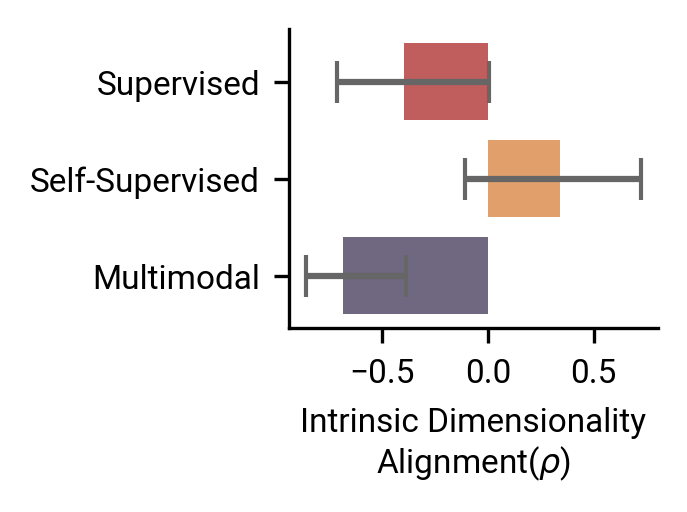

In [6]:

# Create the plot DataFrame
plot_df = pd.DataFrame({
    "model_type": model_types,
    "test_type": test_types,
    "correlations": correlation_values,
    "ci_lower": ci_lower_bounds,
    "ci_upper": ci_upper_bounds
})

# Calculate the error bars
plot_df['error_low'] = plot_df['correlations'] - plot_df['ci_lower']
plot_df['error_high'] = plot_df['ci_upper'] - plot_df['correlations']

# Example color map, adjust as needed

# Plotting
fig, ax = plt.subplots(figsize=(FIGWIDTH/3, FIGWIDTH/4))
sns.barplot(
    data=plot_df,
    x="correlations",
    y="model_type",
    hue="model_type",
    ax=ax,
    hue_order=["supervised", 'self-supervised', 'multimodal'],
    order=["supervised", 'self-supervised', 'multimodal'],
    palette=[CMAP[1], CMAP[2], CMAP[3]]
)

plot_df = plot_df.sort_values(by="model_type",ascending=False).reset_index(drop=True)

# Add error bars
for i, row in plot_df.iterrows():
    ax.errorbar(
        y=i,
        x=row['correlations'],
        xerr=[[row['error_low']], [row['error_high']]],
        fmt='none',
        c=CMAP[-1],
        capsize=5
    )

# Customize the labels
ax.set_xlabel("Intrinsic Dimensionality\n" + r"Alignment($\rho$)")
ax.set_ylabel("")
ax.set_yticklabels(["Supervised","Self-Supervised","Multimodal"])


plt.tight_layout()
plt.show()


fig.savefig(join(PROJECT_ROOT, "figures", "bootstrapped_id.pdf"), bbox_inches="tight")
fig.savefig(join(PROJECT_ROOT, "figures", "bootstrapped_id.svg"), bbox_inches="tight")
fig.savefig(join(PROJECT_ROOT, "figures", "bootstrapped_id.png"), bbox_inches="tight")